In [358]:
# Imports!
# !pip install qiskit
import numpy as np
from qiskit import QuantumCircuit, execute, transpile, Aer, IBMQ
from qiskit.visualization import *
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, IBMQ, execute
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService
import math

In [359]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

edge_list = [[0,1],
               [0,3],
               [1,2],
               [1,4],
               [2,5],
               [3,4],
               [4,5]]
num_vertex = 6

In [360]:
var_qubits = QuantumRegister(num_vertex, name='v')
edge_qubits = QuantumRegister(len(edge_list), name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(num_vertex, name='cbits')
qc = QuantumCircuit(var_qubits, edge_qubits, output_qubit, cbits)

def edgeColor_oracle(qc, edge_list, edge_qubits):
    # Compute edges
    i = 0
    for edge in edge_list:
        XOR(qc, edge[0], edge[1], edge_qubits[i])
        i += 1

    # Flip 'output' bit if all edges are satisfied
    qc.mcx(edge_qubits, output_qubit)

    # Uncompute edges to reset edge-checking bits to 0
    i = 0
    for edge in edge_list:
        XOR(qc, edge[0], edge[1], edge_qubits[i])
        i += 1

edgeColor_oracle(qc, edge_list, edge_qubits)

In [361]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [362]:
# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

itrs = ((math.pi)*math.isqrt(num_vertex))/4
itrs = int(math.ceil(itrs))

for itr in range(0, itrs):
    edgeColor_oracle(qc, edge_list, edge_qubits)
    qc.barrier()  # for visual separation
    # Apply our diffuser
    qc.append(diffuser(num_vertex), list(range(num_vertex)))

# Measure the variable qubits
qc.measure(var_qubits, cbits)

# Setting up and running the QASM simulator.
backend = Aer.get_backend('qasm_simulator') # Choosing the simulator we want to use
job = execute(qc, backend, shots = 1024) # Running the simulator - specifying the circuit we want to simulate and the number of times we want to simulate it (shots)
result = job.result() # Getting the result from the simulator

Result(backend_name='qasm_simulator', backend_version='0.13.0', qobj_id='', job_id='98e37948-d355-421d-a2a6-196951fba619', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x24': 5, '0x4': 5, '0xe': 3, '0x37': 6, '0x19': 7, '0x36': 5, '0x3d': 6, '0x14': 7, '0x34': 7, '0x3f': 6, '0x1e': 6, '0x3b': 7, '0x1': 10, '0x25': 10, '0x35': 6, '0xf': 6, '0xc': 6, '0x28': 6, '0xa': 5, '0x2c': 6, '0x27': 7, '0x22': 4, '0x18': 6, '0x30': 6, '0xb': 4, '0x1b': 9, '0x9': 7, '0x6': 8, '0x1d': 3, '0x5': 7, '0x31': 6, '0x0': 8, '0x12': 5, '0x11': 8, '0x16': 5, '0x17': 10, '0xd': 4, '0x10': 6, '0x26': 9, '0x39': 11, '0x21': 6, '0x2f': 4, '0x1c': 10, '0x3c': 7, '0x8': 7, '0x3a': 7, '0x23': 4, '0x1f': 5, '0x20': 4, '0x3e': 11, '0x33': 8, '0x2d': 7, '0x1a': 8, '0x32': 2, '0x2b': 4, '0x38': 5, '0x2': 11, '0x13': 5, '0x29': 11, '0x3': 8, '0x2e': 4, '0x2a': 324, '0x7': 6, '0x15': 298}), header=QobjExperimentHeader(creg_sizes=[['cbits', 6]], global

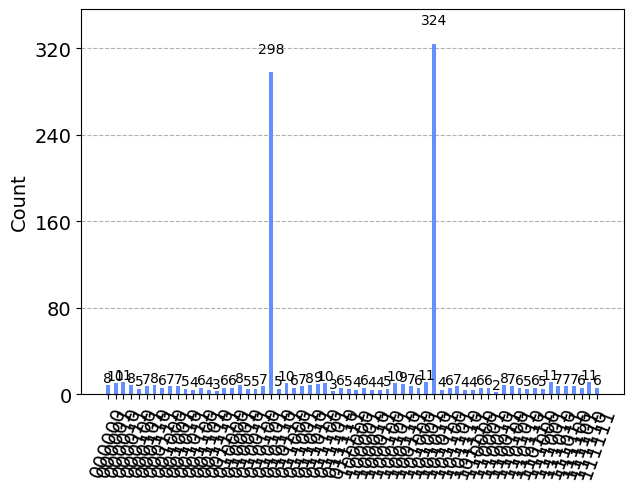

In [367]:
print(result)
counts = result.get_counts() 
for x in counts:
    if(counts[x] > 200):
        print(x)
plot_histogram(counts)